# 뉴스기사 요약해보기

뉴스 기사에 대해 추상적 요약과 추출적 요약을 모두 사용해서 기사제목을 만들어보자.

## 0. 모듈 import

In [1]:
import nltk
#nltk.download('stopwords')

import requests
import numpy as np
import pandas as pd
import os
import re
import time
import urllib.request
import multiprocessing as mp
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from summa.summarizer import summarize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용한다.  
https://github.com/sunnysai12345/News_Summary

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [3]:
print('전체 샘플수 :', (len(data)))
data.info()

전체 샘플수 : 98401
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


데이터의 개수는 98401개로 결측치는 없다.  
각 뉴스문장과 그 헤드라인을 이루는 문자열로 구성되어있다.

## 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

위에 말했듯이 결측치는 따로 없으므로 중복되는 샘플만 제거해 주자.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text는 41개, 헤드라인은 121개의 중복이 존재한다.  
헤드라인 자체는 내용이 달라도 같을 수 있지만, 뉴스 내용은 아니므로,  
중복 데이터들을 drop_duplicates()을 사용해서 제거해 주자.

In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

위의 불용어 중 뉴스의 헤드라인을 구성하는데 도움될만한 단어를 몇개 제외해보자.

In [8]:
exclusion = ['but', 'no', 'not', 'nor', 'only', 'while', 'before', 'after', 'under', 'again', 'further']

my_stopwords = list(filter(lambda word: word not in exclusion, stopwords.words('english')))
print(my_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'because', 'as', 'until', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',

 모든 영어 문자를 소문자로 만들고, 섞여있는 html 태그를 제거하고,  
정규 표현식을 통해 각종 특수문자를 제거하고, 위에서 정의한 사전들을 이용해서  
필요없는 단어들을 제외하는 함수를 만든다.

단 짧은 헤드라인의 경우는 문장 요약 결과문이 자연스러운 문장이 되려면  
불용어들이 남아있는게 더 좋을 것 같으므로 따로 불용어를 제거할지를 정하는 인자를 추가하자.

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

멀티 프로세싱을 이용해서 내용과 헤드라인을 전처리하자.

In [10]:
start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

In [11]:
data['clean_text'] = preprocess_data(data['text'])
print(data['clean_text'])

data['clean_headlines'] = preprocess_data(data['headlines'], remove_stopwords=False)
print(data['clean_headlines'])

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

8.744233131408691  seconds
0        saurav kant alumnus upgrad iiit pg program mac...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india wickets fourth odi ...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: clean_text, Length: 98360, dtype: object
5.774643182754517  seconds
0        upgrad learner switches to career in ml al wit...
1        delhi techie wins free food from swiggy for on...
2        new zealand end rohit sharma led india match w...
3        aegon life iterm insurance plan helps customer...
4        have 

headlines          0
text               0
clean_text         0
clean_headlines    0
dtype: int64

데이터 처리 후에도 딱히 결측치는 생기지 않았다.

In [12]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 이상치 제거
text와 headline의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 61
텍스트의 평균 길이 : 36.091744611630745
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


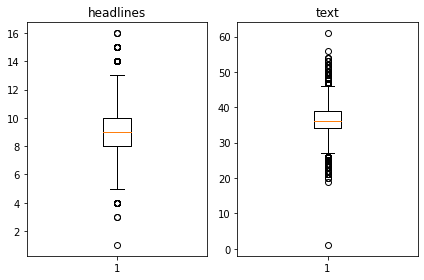

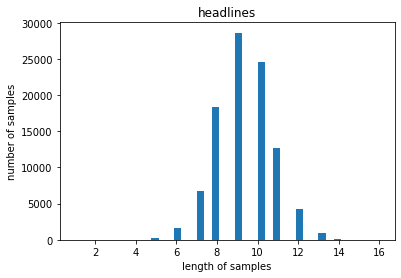

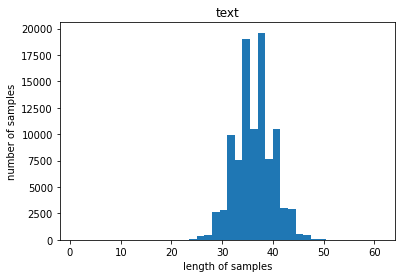

In [13]:
text_len = [len(s.split()) for s in data['clean_text']]
headlines_len = [len(s.split()) for s in data['clean_headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

그래프를 보면 앞의 빈 데이터가 이상한 것 같다.

위에서 뉴스 내용이 한 단어로 이루어진 문장을 출력해보자.

In [14]:
outlier = [len(s.split()) == 1 for s in data['clean_text']]
data[outlier]

,headlines,text,clean_text,clean_headlines
52,headlines,text,text,headlines


딱봐도 정상적이지 않은 데이터가 한 개 있다.  
혹시 모르니 마찬가지로 길이가 2 이상 15 이하인 문장을 출력해보자.

In [15]:
outlier = [1 < len(s.split()) < 15 for s in data['clean_text']]
data[outlier]

,headlines,text,clean_text,clean_headlines


위의 단 하나의 비정상적 데이터를 제외하면 15이하의 단어로 구성된 문장은 없다.  
위의 이상 데이터를 지워주자.

In [16]:
outlier = [len(s.split()) == 1 for s in data['clean_text']]
data = data.drop(data[outlier].index)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98359


### 샘플의 최대 길이 정하기

다시 그래프를 그리고 훈련에 사용할 문장의 최대 길이를 정해주자.  

텍스트의 최소 길이 : 19
텍스트의 최대 길이 : 61
텍스트의 평균 길이 : 36.09210138370663
헤드라인의 최소 길이 : 3
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299616710214622


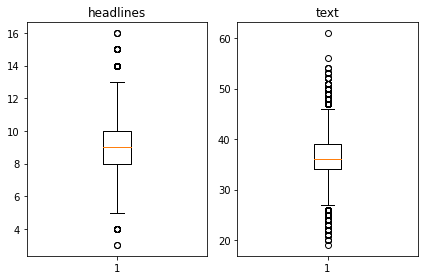

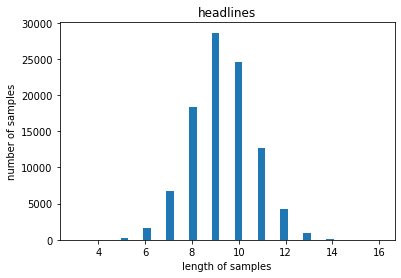

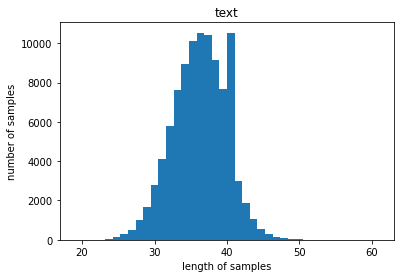

In [17]:
text_len = [len(s.split()) for s in data['clean_text']]
headlines_len = [len(s.split()) for s in data['clean_headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프를 토대로 대략적으로 헤드라인은 12개, 뉴스문장은 43개 정도의  
최대 길이로 설정을 하고 그 때의 데이터를 보자.

In [18]:
text_max_len = 43
headline_max_len = 12

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    

below_threshold_len(text_max_len, data['clean_text'])
below_threshold_len(headline_max_len,  data['clean_headlines'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9776329568214398
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880336318994704


97퍼의 거의 모든 데이터를 만족하는 길이인 것 같다.  
그럼 최대길이를 넘는 데이터를 제거하자.

In [20]:
data = data[data['clean_text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['clean_headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95015


### 시작 토큰과 종료 토큰 추가하기

시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가하자.

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['clean_headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['clean_headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,clean_text,clean_headlines,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india recorded lowest odi total new zealand af...,india get all out for their lowest odi total i...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해놓자.

In [22]:
encoder_input = np.array(data['clean_text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 / 테스트 데이터 분리

우선 샘플들을 잘 섞어주자.

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 8:2 비율로 훈련 / 테스트 데이터를 나누자.

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19003


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76012
훈련 레이블의 개수 : 76012
테스트 데이터의 개수 : 19003
테스트 레이블의 개수 : 19003


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68174
등장 빈도가 6번 이하인 희귀 단어의 수: 46459
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21715
단어 집합에서 희귀 단어의 비율: 68.14768093408044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.46134702096762


7회 미만인 단어들의 등장 빈도는 3.46으로 모두 제거해도 상관없을 것 같다.

그리고 단어장은 22000 크기로 만들어보자.

In [28]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4755, 5, 16, 14, 1686, 162, 1483, 2691, 4410, 62, 356, 224, 64, 3927, 603, 862, 274, 573, 2455, 1774, 853, 891, 1967, 321, 257, 348, 2902, 7529, 2, 10499, 356, 4410, 5972, 158, 10724, 321, 1, 232], [36, 1387, 3668, 58, 3771, 1087, 463, 3549, 165, 70, 67, 6482, 575, 992, 3, 6566, 32, 1209, 122, 503, 129, 7114, 644, 20, 3668, 256, 15, 654, 184, 1228, 906], [800, 1147, 77, 946, 1661, 1795, 2998, 1366, 171, 4, 172, 12655, 1, 5245, 16310, 1126, 7300, 1126, 6, 7196, 1799, 1795, 171, 2734, 297, 407, 1493, 1147, 946, 8782, 2, 72, 21716, 3625]]


헤드라인에 대해서도 동일한 작업을 수행하자.

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29610
등장 빈도가 5번 이하인 희귀 단어의 수: 19347
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10263
단어 집합에서 희귀 단어의 비율: 65.33941236068895
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.7402191505829165


6번 미만이 단어의 비율이 4.74로 역시 제거해도 괜찮을 듯 하다.

헤드라인은 대략 10000개 정도의 단어장으로 구성하자.

In [32]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 65, 26, 1603, 272, 3160, 188, 61, 5, 128, 1269, 648], [1, 3088, 4891, 659, 3501, 53, 6, 1295, 212, 4, 25], [1, 4892, 864, 5775, 864, 664, 7, 948, 2565, 3, 207], [1, 131, 2615, 8, 4721, 2416, 5, 5307, 484, 34], [1, 450, 699, 163, 74, 8666, 88, 125, 19, 11, 7529, 49, 604]]
target
decoder  [[65, 26, 1603, 272, 3160, 188, 61, 5, 128, 1269, 648, 2], [3088, 4891, 659, 3501, 53, 6, 1295, 212, 4, 25, 2], [4892, 864, 5775, 864, 664, 7, 948, 2565, 3, 207, 2], [131, 2615, 8, 4721, 2416, 5, 5307, 484, 34, 2], [450, 699, 163, 74, 8666, 88, 125, 19, 11, 7529, 49, 604, 2]]


매핑을 진행하면서 길이가 0이된 문장들을 제거하자.  
decoder_input, decoder_target같은 경우는 토큰이 있기 때문에  
길이가 1인 문장들을 제거하면된다.

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76012
훈련 레이블의 개수 : 76012
테스트 데이터의 개수 : 19003
테스트 레이블의 개수 : 19003


### 패딩하기

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### 인코더 설계

In [35]:
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 256)      5632000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

In [38]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 256)      5632000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
297/297 [==============================] - 189s 609ms/step - loss: 5.9586 - val_loss: 5.1374
Epoch 2/50
297/297 [==============================] - 181s 609ms/step - loss: 5.0260 - val_loss: 4.6240
Epoch 3/50
297/297 [==============================] - 182s 614ms/step - loss: 4.4937 - val_loss: 4.2444
Epoch 4/50
297/297 [==============================] - 183s 616ms/step - loss: 4.0906 - val_loss: 4.0171
Epoch 5/50
297/297 [==============================] - 183s 617ms/step - loss: 3.7718 - val_loss: 3.8654
Epoch 6/50
297/297 [==============================] - 184s 620ms/step - loss: 3.5178 - val_loss: 3.7357
Epoch 7/50
297/297 [==============================] - 185s 623ms/step - loss: 3.2953 - val_loss: 3.6578
Epoch 8/50
297/297 [==============================] - 185s 622ms/step - loss: 3.1032 - val_loss: 3.6091
Epoch 9/50
297/297 [==============================] - 185s 622ms/step - loss: 2.9303 - val_loss: 3.5704
Epoch 10/50
297/297 [==============================] - 184s 621m

훈련 과정을 시각화 해보자.

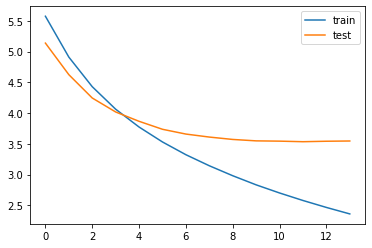

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들자.

In [44]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트하기

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 10개의 샘플에 대해서 실제 헤드라인과 비교해보자.

In [53]:
for i in range(40, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actor turned politician kamal haasan revealed held secret meeting contemporary rajinikanth car tell decision entering politics haasan added promised maintain dignity ended opposite political camps while haasan launched political party wednesday rajinikanth announced entry politics last year 
실제 헤드라인 : secretly met rajinikanth before entering politics haasan 
예측 헤드라인 :  kamal haasan to join politics for support politics


원문 : golfer tiger woods apologised family television after extramarital affairs exposed former cyclist lance armstrong apologised after admitting took performance enhancing drugs interview oprah winfrey ex us sprinter jones broke while apologising using performance enhancing drugs cost three olympic golds 
실제 헤드라인 : which are biggest after fall from grace 
예측 헤드라인 :  tiger woods apologises for calling gay sex comment


원문 : least people killed several others injured friday following suicide bombing inside shia mosque afghan capital kabul officials said attack occu

추상적 요약 결과를 보면 어느 정도 실제 헤드라인의 기사와 비슷한 어휘들을 사용한 것을 볼 수 있다.  
원문에 있는 단어들이 보이기도 하지만 새로운 단어로 헤드라인을 만든 것을 볼 수 있다.

마지막 헤드라인을 보면 뜬금없이 원문에도 없는 'crore' 라는 단어를 사용하는데,  
이는 학습한 기사의 원문들이 투자 등의 기사가 나올 때 저 단어가 많이 사용되어서 그렇게 학습된게 아닌가 싶다.

영어를 못해서 문법적인 부분은 잘모르겠만, 조금씩 어색해 보이는 부분도 보인다.  
기존의 임베딩크기와 히든레이어 크기를 늘렸지만, 아직 모델의 성능을 늘려야 할 것 같다.

## 5. Summa을 이용해서 추출적 요약해보기

Summa 라이브러리의 summarize함수를 이용해서 추출적 요약을 해보자.

In [54]:
#data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data['text'][200])
print('Headline:')
print(summarize(data['text'][200], ratio=0.5)) # 0.5로 요약

Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year. Harmanpreet, who was named in the ICC Team of the Year 2018, helped India reach the semi-finals of the ICC Women's World T20 2018 last November.
Headline:
Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year.


추상적 요약과 마찬가지로 10개의 샘플에 대해서 실제 헤드라인과 비교해보자.  
원문 자체가 짧아서 요약 비율을 0.4이상을 주어야 요약된 문장을 얻을 수 있었다.

In [55]:
for i in range(39, 49):
    print("원문 :", data['text'][i])
    print("실제 헤드라인 :", data['headlines'][i])
    print("예측 헤드라인 :", summarize(data['text'][i], ratio=0.4))
    print("\n")

원문 : Gabrielle Reilly, a 22-year-old US woman, created earrings for her Apple AirPods and put it up for sale online for $20 (about Ã¢ÂÂ¹1,500). "I absolutely refuse to lose them (AirPods)...So I made earrings," she explained. The earrings, which took her over an hour to make, debuted in a video on Twitter that has since garnered over three million views.
실제 헤드라인 : Woman turns Apple AirPods into earrings to avoid losing them
예측 헤드라인 : "I absolutely refuse to lose them (AirPods)...So I made earrings," she explained.


원문 : Ex-ICICI Bank CEO Chanda Kochhar said she's "utterly disappointed, hurt and shocked" by the bank's decision to terminate her. Kochhar said she served ICICI for 34 years with utmost honesty and integrity and that ultimately truth will prevail. Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral
실제 헤드라인 : Shocked, hurt by ICICI's decision, truth will prevail: Kochhar
예측 헤드라인 : Adding that

추출적 요약이기 때문에 원문에 있는 단어들이 그대로 사용된 것을 확인 할 수 있다.  
문법적인 형식은 추상적 요약보다 더 괜찮아 보이는 것 같다.  
다만 그 내용이 핵심적인 내용을 제대로 표현하지 못하고 어색한 부분들이 보인다.

## 6. 회고

이번 프로젝트를 하면서 자연어를 요약에 대한 기본 지식을 얻은 것 같다.  
특히 새롭게 seq2seq 와 encoder 와 decoder에 대해 공부하며 많은 것을 알게되었다.

뉴스기사를 seq2seq를 이용해서 추상적 요약을 해봤는데, 원문을 나타내는 핵심적인 단어들은  
잘 찾는 것 같지만, 원문과 상관없는 단어가 포함되기도 하고 문법적으로 잘 맞지 않는 문장들을  
생성하기도 하였다. 아직 모델의 완성도가 떨어진다고 볼 수 있다.

몇가지 생각해 볼 부분은 일단 뉴스 기사의 원문 자체가 너무 짧은 것 같고,  
특수 문자 등을 전부 제거하면서 문장 자체를 파악하기가 어려워진 것 같기도 하다.  
이런 부분은 문장의 구분을 그대로 나두고 학습시켜보는 등 여러 방법을 나중에 시도해 보면 좋을 것 같다.